# Monte Carlo

This notebook creates three files. For a given number of market situations and a given set of prices, it creates features and saves them in the `demand_prediction_data` file. Next, for each market situation and each price, the notebook runs multiple simulations and tracks purchases. The notebook then calculates the probabilities of a purchase for each price and market situation and stores them in the `PEW_comparison` file.

After this, for one price, the time between adjustments of prices gets split into B parts and for each purchase the time slot o fit is tracked. At the end, it outputs a probability for each time slot, which corresponds to how likely a purchase is in this time slot after a price adjustment. The probabilities are saved in the `cond_prob_out` file. The time horizon is 1.

Because of performance reasons the number of simulations and the number of considered market situations used in the start configuration are smaller than the ones used for the data for the paper. The inline comments show the values used in the paper, which lead to a longer runtime.

In [1]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
numberPlayers = 5
timeHorizon = 1
numberMarketReactionEvents = round(1.1*timeHorizon)
meanTimeBetweenCustomerArrival = 2
numberOfCustomerEvents = round(1.1*timeHorizon/meanTimeBetweenCustomerArrival)
prices = np.arange(0,15.1,0.2)   # values used for paper: (np.arange(0,15.1,0.1))
watchedCompany = 0
numberSimulations = 100  # value used for paper: 10000
numberConsideredMarketSituations = 10   # value used for paper: 40
m = 2
numberCustomerEvents = 4
reactionTimeCompany = timeHorizon
intensity_price = 7
price_index = np.where(prices==intensity_price)[0][0]
bb = 20
strategies = ["S1","S2","S3"]
random.seed(12530586)

In [3]:
pricesCompanies = np.array([round(random.uniform(6,16),2) for _ in range(numberPlayers)])
qualityCompanies = np.array([round(random.uniform(0.5,5.5)) for _ in range(numberPlayers)])
ratingCompanies = np.array([round(random.uniform(90,100),1) for _ in range(numberPlayers)])

In [4]:
def explanatoryVariables(explanatoryVariable, numberPrice, marketSituation):
    return {
        '0' : 1,
        '1' : priceRanksForFirm[marketSituation][numberPrice],
        '2' : 1 if priceRanksForFirm[marketSituation][numberPrice]==1 else 0,
        '3' : qualityRankForFirm[marketSituation],
        '4' : ratingRanks[marketSituation][watchedCompany],
        '5' : prices[numberPrice],
        '6' : prices[numberPrice] - min([pricesCompaniesPred[j][marketSituation] for j in range(numberPlayers) if j!=watchedCompany]) if numberPlayers > 1 else 0,
        '7' : qualityCompaniesPred[watchedCompany][marketSituation],
        '8' : ratingCompaniesPred[watchedCompany][marketSituation],
        '9' : 15 - (prices[numberPrice]+0.5*qualityCompaniesPred[watchedCompany][marketSituation]+0.25*(100-ratingCompaniesPred[watchedCompany][marketSituation])) if(
        (prices[numberPrice]+0.5*qualityCompaniesPred[watchedCompany][marketSituation]+0.25*(100-ratingCompaniesPred[watchedCompany][marketSituation])) <
        min([pricesCompaniesPred[j][marketSituation] +0.5*qualityCompaniesPred[j][marketSituation]+0.25*(100-ratingCompaniesPred[j][marketSituation]) for j in range(numberPlayers) if j!= watchedCompany]))
        else 0,
    }[str(explanatoryVariable)]

In [5]:
pricesCompaniesPred = np.array([[round(random.uniform(6,16),2) for _ in range(numberConsideredMarketSituations)]  for _ in range(numberPlayers)])
qualityCompaniesPred = np.array([[round(random.uniform(0.5,5.5)) for _ in range(numberConsideredMarketSituations)]  for _ in range(numberPlayers)])
ratingCompaniesPred = np.array([[round(random.uniform(90,100),1) for _ in range(numberConsideredMarketSituations)] for _ in range(numberPlayers)])

priceRanksForFirm = np.array([[1 +  
              sum([1 for i in range(numberPlayers) if prices[j]> pricesCompaniesPred[i][w] and i!=watchedCompany]) +
              sum([1 for i in range(numberPlayers) if prices[j]== pricesCompaniesPred[i][w] and i!=watchedCompany])/2
              for j in range(len(prices))]for w in range(numberConsideredMarketSituations)])
qualityRankForFirm = np.array([(1 +  
              sum([1 for i in range(numberPlayers) if qualityCompaniesPred[watchedCompany][w]> qualityCompaniesPred[i][w] and i!=watchedCompany]) +
              sum([1 for i in range(numberPlayers) if qualityCompaniesPred[watchedCompany][w]== qualityCompaniesPred[i][w] and i!=watchedCompany])/2)for w in range(numberConsideredMarketSituations)])
                         
ratingRanks = np.array([[1 +  
              sum([1 for i in range(numberPlayers) if ratingCompaniesPred[j][w]> ratingCompaniesPred[i][w] and i!=j]) +
              sum([1 for i in range(numberPlayers) if ratingCompaniesPred[j][w]== ratingCompaniesPred[i][w] and i!=j])/2
              for j in range(numberPlayers)]for w in range(numberConsideredMarketSituations)])

numberExplanatoryVariables = 10

valuesExplanatoryVariables = [[[explanatoryVariables(explanatoryVariable, numberPrice, w) for explanatoryVariable in range(numberExplanatoryVariables)] for numberPrice in range(len(prices))]for w in range(numberConsideredMarketSituations)]

with open('demand_prediction_data_S3.csv', 'w') as file:
    writer = csv.writer(file, delimiter='\t')
    for marketSituation in range(numberConsideredMarketSituations):
        for numberPrice in range(len(prices)):
            line = list(valuesExplanatoryVariables[marketSituation][numberPrice])
            line.remove(1)
            line.insert(0, prices[numberPrice])
            line.insert(0, marketSituation+1)
            writer.writerow(line)

In [6]:
def price_if_smaller_else(price, price_smaller, else_min, prices_comp, c):
    return(price if min(prices_comp[comp] for comp in range(numberPlayers) if comp!=c)< price_smaller else round(min([max(else_min, prices_comp[company]-0.5) for company in range(numberPlayers) if company != c]),2))

s1 = {
        '0' : lambda pricesCompanies, c: round(random.uniform(0,15),2),
        '1' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '2' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '3' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '4' : lambda pricesCompanies, c: round(random.uniform(5,15),2)
    }

s2 = {
        '0' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '1' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '2' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '3' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '4' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c)
    }

s3 = {
        '0' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '1' : lambda pricesCompanies, c: price_if_smaller_else(9,4,3.9,pricesCompanies,c),
        '2' : lambda pricesCompanies, c: price_if_smaller_else(12,6,5.9,pricesCompanies,c),
        '3' : lambda pricesCompanies, c: round(random.uniform(11,11),2),
        '4' : lambda pricesCompanies, c: round(random.uniform(13,13),2)
    }

In [7]:
def calculateTimeOfAdjustmentsCompany(company, i, timeBetweenMarketEventsCompany):
    if i==0:
        if company != watchedCompany:
            return(random.uniform(0,1))
        else:
            return(reactionTimeCompany)
    else:
        return(calculateTimeOfAdjustmentsCompany(company, i-1, timeBetweenMarketEventsCompany)+ timeBetweenMarketEventsCompany[company][i])
    
def calculateTimeOfCustomerArrival(customer, timeBetweenMarketEventsCustomer):
    if customer==0:
        return timeBetweenMarketEventsCustomer[customer]
    else:
        return(calculateTimeOfCustomerArrival(customer-1, timeBetweenMarketEventsCustomer) + timeBetweenMarketEventsCustomer[customer])

def calculatePrices(pricesCompaniesAdjustments, adjustingFirm, strategy):
    for i in range(1,len(pricesCompaniesAdjustments)-1):        
        pricesCompaniesAdjustments[i][adjustingFirm[i]] = strategy[str(adjustingFirm[i])](pricesCompaniesAdjustments[i-1],adjustingFirm[i])
    pricesCompaniesAdjustments[len(pricesCompaniesAdjustments)-1] = pricesCompaniesAdjustments[len(pricesCompaniesAdjustments)-2]
    return pricesCompaniesAdjustments

In [8]:
timeBetweenMarketEventsCompany = np.array([[[[[random.uniform(0.8,1.2) for i in range(m)] for company in range(numberPlayers)] for _ in range(numberSimulations)]for w in range(numberConsideredMarketSituations)] for _ in range(len(prices))])
timeOfAdjustmentsCompany = np.array([[[[[calculateTimeOfAdjustmentsCompany(company ,i, timeBetweenMarketEventsCompany[p,w,simulationNumber]) for i in range(m)] for company in range(numberPlayers)] for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])
priceAdjustmentsBeforeHorizon = np.array([[[set([timeOfAdjustmentsCompany[p,w,simulationNumber].flatten()[i] for i in range(len(timeOfAdjustmentsCompany[p,w,simulationNumber].flatten())) if timeOfAdjustmentsCompany[p,w,simulationNumber].flatten()[i] < timeHorizon]) for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])

priceAdjustmentsBeforeHorizon = np.array([[[sorted(priceAdjustmentsBeforeHorizon[p,w,simulationNumber])+[timeHorizon] for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])

numberPriceAdjustmentsBeforeHorizon = np.array([[[len(priceAdjustmentsBeforeHorizon[p,w,simulationNumber]) for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])

timeMarketEvents = np.array([[[[0 if i==0 else priceAdjustmentsBeforeHorizon[p,w,simulationNumber][i-1] for i in range(numberPriceAdjustmentsBeforeHorizon[p,w,simulationNumber]+1)]for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])

adjustingFirm = np.array([[[[min(np.where(timeOfAdjustmentsCompany[p,w,simulationNumber]==priceAdjustmentsBeforeHorizon[p,w,simulationNumber][i] )[0]) if priceAdjustmentsBeforeHorizon[p,w,simulationNumber][i]!= timeHorizon and i!=0 else -1 for i in range(numberPriceAdjustmentsBeforeHorizon[p,w,simulationNumber])] for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])
timeBetweenCustomerEvents = np.array([[[[meanTimeBetweenCustomerArrival*np.random.exponential() for _ in range(numberCustomerEvents)]for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])
timeCustomerEvents = np.array([[[[calculateTimeOfCustomerArrival(customer, timeBetweenCustomerEvents[p,w,simulationNumber]) for customer in range(numberCustomerEvents)] for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])

randomCustomerScoringQuality = np.array([[[[random.uniform(0,1) for _ in range(numberCustomerEvents)] for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])
randomCustomerScoringRating = np.array([[[[random.uniform(0,0.5) for _ in range(numberCustomerEvents)] for simulationNumber in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])
                         
customerScoringQualityRating = np.array([[[[[(randomCustomerScoringQuality[p,w,s][c]*qualityCompaniesPred[k,w] +
    randomCustomerScoringRating[p,w,s][c]*(100-ratingCompaniesPred[k,w]))for k in range(numberPlayers)] for c in range(numberCustomerEvents)] for s in range(numberSimulations)]for w in range(numberConsideredMarketSituations)]for p in range(len(prices))])
pricesCompanies = np.array([[[pricesCompaniesPred[k,w] if k!=watchedCompany else prices[a] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]  for k in range(numberPlayers)])
pricesCompaniesAdjustments = np.array([[[[[pricesCompanies[k,a,w]  for k in range(numberPlayers)]for _ in range(numberPriceAdjustmentsBeforeHorizon[a,w,s])] for s in range(numberSimulations)] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))])
pricesCompaniesAdjustments = np.array([[[[np.array(calculatePrices(pricesCompaniesAdjustments[a,w,s], adjustingFirm[a,w,s], globals()["s{}".format(strat+1)])) for s in range(numberSimulations)] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))])

gen = np.array([[[[[x for x in range(numberCustomerEvents) if timeMarketEvents[a,w,s][i]< timeCustomerEvents[a,w,s][x]< timeMarketEvents[a,w,s][i+1]] for i in range(numberPriceAdjustmentsBeforeHorizon[a,w,s])] for s in range(numberSimulations)] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))])

randomCustomerScoring = np.array([[[[[[[(pricesCompaniesAdjustments[strat,a,w,s][i,k] + customerScoringQualityRating[a,w,s,c,k]) for k in range(numberPlayers)]for c in gen[a,w,s][i]]for i in range(numberPriceAdjustmentsBeforeHorizon[a,w,s])] for s in range(numberSimulations)] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))])
randomCustomerDecision = np.array([[[[[[np.argmin(randomCustomerScoring[strat,a,w,s][i][c]) if min(randomCustomerScoring[strat,a,w,s][i][c])< random.uniform(5,15) else -1 for c in range(len(gen[a,w,s][i]))]for i in range(numberPriceAdjustmentsBeforeHorizon[a,w,s])] for s in range(numberSimulations)] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))])
As = np.array([[[[[np.count_nonzero(np.hstack(randomCustomerDecision[strat,a,w,s])== k) for k in range(numberPlayers)]for s in range(numberSimulations)] for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))])

A = np.array([[[[[1/numberSimulations*np.count_nonzero(As[strat,a,w,:,k]==x) for k in range(numberPlayers)]for x in range(6)]for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))])
P_ori = [[[1- A[strat,a,w,0,watchedCompany]for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))]
P_ori2 = [[[sum([A[strat,a,w,x,watchedCompany]for x in range(2,6)])for w in range(numberConsideredMarketSituations)] for a in range(len(prices))]for strat in range(len(strategies))]

EW_ori = [[[prices[a]*P_ori[strat][a][w] for w in range(numberConsideredMarketSituations)]for a in range(len(prices))]for strat in range(len(strategies))]

for strat in range(len(strategies)):
    with open('PEW_comparison_{}.csv'.format(strategies[strat]), 'w') as file:
        writer = csv.writer(file, delimiter='\t')
        for w in range(numberConsideredMarketSituations):
            for a in range(len(prices)):
                line = [w+1,prices[a],P_ori[strat][a][w], P_ori2[strat][a][w], EW_ori[strat][a][w]]
                writer.writerow(line)

w = 0

customerScoringQualityRating = np.array([[[(randomCustomerScoringQuality[price_index,w,s][c]*2 +
    randomCustomerScoringRating[price_index,w,s][c]*(100-98))for k in range(numberPlayers)] for c in range(numberCustomerEvents)] for s in range(numberSimulations)])

pricesCompanies = np.array([intensity_price+20.5+2*(k-2) if k!=watchedCompany else intensity_price  for k in range(numberPlayers)])
pricesCompaniesAdjustments = np.array([[[pricesCompanies[k]  for k in range(numberPlayers)]for _ in range(numberPriceAdjustmentsBeforeHorizon[price_index,w,s])] for s in range(numberSimulations)])
pricesCompaniesAdjustments = np.array([[np.array(calculatePrices(pricesCompaniesAdjustments[s], adjustingFirm[price_index,w,s], globals()["s{}".format(strat+1)])) for s in range(numberSimulations)]for strat in range(len(strategies))])

gen = np.array([[list([x for x in range(numberCustomerEvents) if timeMarketEvents[price_index,w,s][i]< timeCustomerEvents[price_index,w,s][x]< timeMarketEvents[price_index,w,s][i+1]]) for i in range(numberPriceAdjustmentsBeforeHorizon[price_index,w,s])] for s in range(numberSimulations)] )

randomCustomerScoring = np.array([[[[[(pricesCompaniesAdjustments[strat,s][i,k] + customerScoringQualityRating[s,c,k]) for k in range(numberPlayers)]for c in gen[s][i]]for i in range(numberPriceAdjustmentsBeforeHorizon[price_index,w,s])] for s in range(numberSimulations)]for strat in range(len(strategies))])
randomCustomerDecision = np.array([[[[np.argmin(randomCustomerScoring[strat,s][i][c]) if min(randomCustomerScoring[strat,s][i][c])< random.uniform(5,15) else -1 for c in range(len(gen[s][i]))]for i in range(numberPriceAdjustmentsBeforeHorizon[price_index,w,s])] for s in range(numberSimulations)]for strat in range(len(strategies))])

b = np.array([[[int(round((timeCustomerEvents[price_index,w,s][c]+1/bb/2)*bb))for c in range(len(gen[s][i]))]for i in range(numberPriceAdjustmentsBeforeHorizon[price_index,w,s])] for s in range(numberSimulations)])

At = np.array([[[sum([sum([sum([1 if b[s][i][c]==t and randomCustomerDecision[strat,s][i][c]==k  else 0 for c in range(len(gen[s][i]))])for i in range(numberPriceAdjustmentsBeforeHorizon[price_index,w,s])])for s in range(numberSimulations)])for k in range(numberPlayers)]for t in range(reactionTimeCompany*bb+1)]for strat in range(len(strategies))])

for strat in range(len(strategies)):
    with open('cond_prob_out_{}.csv'.format(strategies[strat]), 'w') as file:
        writer = csv.writer(file, delimiter='\t')
        for t in range(reactionTimeCompany*bb+1):
            line = [t/bb, At[strat,t][watchedCompany]/numberSimulations]
            writer.writerow(line)

x = [t/bb for t in range(1,reactionTimeCompany*bb+1)]

plt.plot(x, [At[0,t][watchedCompany]/numberSimulations for t in range(1,len(x)+1)], 'b-', label='S1')
plt.plot(x, [At[1,t][watchedCompany]/numberSimulations for t in range(1,len(x)+1)], 'r-', label='S2')
plt.plot(x, [At[2,t][watchedCompany]/numberSimulations for t in range(1,len(x)+1)], 'g-', label='S3')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('E(λ$_t$)')

Simulated expected sales intensities of firm 1 over one period of time for different competitive setups S1-S3, starting in market situation S0 , cf.

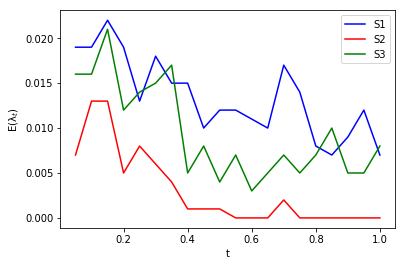

In [9]:
plt.show()